## Image classification uning a CNN

The CIFAR-10 dataset is a widely used collection of images in the field of computer vision. It consists of 60000 (50000 for the training and 10000 for the test) 32x32 color images across 10 different classes, with each class containing 6,000 images. These classes include common objects such as airplanes, automobiles, cats, and dogs. CIFAR-10 serves as a benchmark for image classification tasks and has been instrumental in developing and evaluating machine learning algorithms for image recognition. 
The task of this assignment is to classify the images

In [1]:
#pip install torch torchvision torchaudio

In [2]:
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import numpy as np
from collections import Counter


### Task 0 
Understand what's going on in the two cells below. Do the following experiments: 
1. Run the first and the second cell in a row.
2. Run the first cell and two times in a row the second one.



In [3]:
torch.manual_seed(0)

In [4]:
torch.randint(1, 10 , (1,1))
torch.randint(1, 10 , (1,1))


tensor([[1]])

### Task 1 
Load the [data (You can do it directly in PyTorch)](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) and take some time to inspect the dataset. Report here at least one image per class and a histogram of the distribution of the images of the training and test set. 

In [5]:
#download dataset 
transform = transforms.Compose(
    [transforms.ToTensor()]
     )

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



100%|██████████| 170M/170M [00:01<00:00, 86.7MB/s] 


Una immagine per classe: frog | truck | deer | automobile | bird | horse | ship | cat | dog | airplane


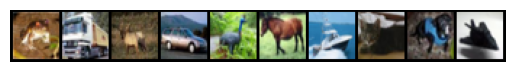

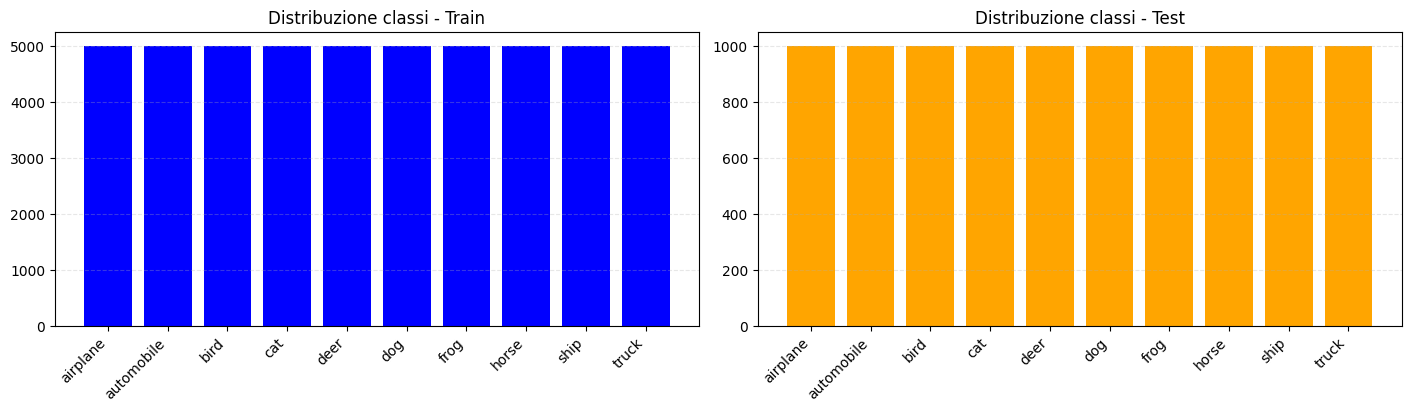

In [6]:
def imshow_noshow(img, ax):
    img = img / 2 + 0.5
    npimg = img.numpy().transpose(1, 2, 0)
    ax.imshow(npimg); ax.axis("off")

classes = list(getattr(trainset, "classes", None) or classes)
picked = set()
imgs, lbls = [], []   

for i in range(len(trainset)):
    img, y = trainset[i]     # transofermed tensor (Normalize(0.5,0.5,0.5))
    if y not in picked:
        picked.add(y)
        imgs.append(img)
        lbls.append(y)
    if len(picked) == len(classes):
        break

# Visualization: using imshow defined in the notebook (img/2 + 0.5)
grid = torchvision.utils.make_grid(imgs, nrow=len(classes))
plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
plt.axis("off")
print("Una immagine per classe: " + " | ".join(classes[y] for y in lbls))
# Counter for each class
train_counts = Counter(trainset.targets)   # list of train label
test_counts  = Counter(testset.targets)    # list of test label

xs = list(range(len(classes)))
train_vals = [train_counts.get(i, 0) for i in xs]
test_vals  = [test_counts.get(i, 0) for i in xs]

# Plotting 
fig, axes = plt.subplots(1, 2, figsize=(14, 4), constrained_layout=True)

axes[0].bar(xs, train_vals, color="blue")
axes[0].set_title("Distribuzione classi - Train")
axes[0].set_xticks(xs)
axes[0].set_xticklabels(classes, rotation=45, ha="right")

axes[1].bar(xs, test_vals, color="orange")
axes[1].set_title("Distribuzione classi - Test")
axes[1].set_xticks(xs)
axes[1].set_xticklabels(classes, rotation=45, ha="right")

for ax in axes:
    ax.grid(axis="y", linestyle="--", alpha=0.3)

plt.show()

### Task 2 
Are the entries in the correct type for the DL framework in PyTorch? How can you arrive at a suitable format for your training pipeline? Be sure to have understood
- The type of each element of the dataset 
- How we can convert it to a suitable type.
- The dimension of the image as a `torch.Tensor` object
- The meaning of each dimension of the images 

Image type: <class 'torch.Tensor'>
Lebel type: <class 'int'>
Dimension of image's tensor: torch.Size([3, 32, 32])
Meaning: [Channel, Height, Width] = [C, H, W]


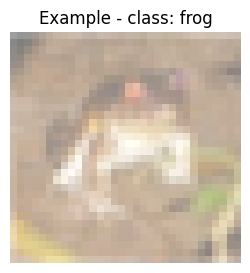

In [7]:
# Take one single element from the dataset
sample_img, sample_label = trainset[0]

# Type of elements
print(f"Image type: {type(sample_img)}") 
print(f"Lebel type: {type(sample_label)}")

# Image dimension
print(f"Dimension of image's tensor: {sample_img.shape}")

print("Meaning: [Channel, Height, Width] = [C, H, W]")

# Example Image 
fig, ax = plt.subplots(figsize=(3, 3))
imshow_noshow(sample_img, ax)
ax.set_title(f"Example - class: {classes[sample_label]}")
plt.show()

### Task 3 
When you arrive at this question you should have each entry as a `torch.Tensor` of shape (3,32, 32) and clear the meaning of each dimension. A good practice in DL is to work with features having mean 0 and standard deviation equal to 1. Convert the dataset of the images in this format. To do so, you can do it from scratch (not recommended) or use the function [`torchvision.transforms.Normalize`](https://pytorch.org/vision/0.8/transforms.html\#torchvision.transforms.Normalize). If you go for this second option, don't forget that we have already transformed our dataset in the previous point, hence, it could be of help using the function [`transforms.Compose`](https://pytorch.org/vision/0.8/transforms.html\#torchvision.transforms.Compose). You can see an example in the tutorial linked above.

Tipo immagine: <class 'torch.Tensor'>
Dimensioni del tensore immagine: torch.Size([3, 32, 32])
Classe corrispondente: frog
Media dei pixel: -0.1886
Deviazione standard dei pixel: 0.4077


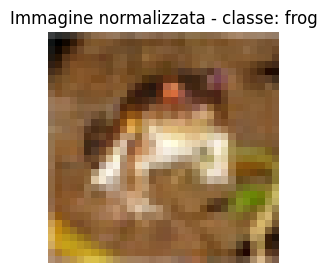

In [8]:
# Definition of trasformation: 
# 1) Convert from image PIL to a torch.Tensor
# 2) Normalize each channel (R,G,B) to average 0 and std 1 
transform_norm = transforms.Compose([                
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),  # mean for each channel
                         (0.5, 0.5, 0.5))  # std for each channel 
])

# Recharge dataset with new trasfirmation (used in task 1)
trainset_norm = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=False, transform=transform_norm)
testset_norm = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=False, transform=transform_norm)

# Sample check 
sample_img, sample_label = trainset_norm[0]
print(f"Tipo immagine: {type(sample_img)}")
print(f"Dimensioni del tensore immagine: {sample_img.shape}")
print(f"Classe corrispondente: {classes[sample_label]}")

# Statistical analysis of the tensor’s pixel values
mean_val = sample_img.mean().item()
std_val = sample_img.std().item()
print(f"Media dei pixel: {mean_val:.4f}")
print(f"Deviazione standard dei pixel: {std_val:.4f}")

# Visualization of the reconverted image to display correct colors
fig, ax = plt.subplots(figsize=(3, 3))
imshow_noshow(sample_img, ax)
ax.set_title(f"Immagine normalizzata - classe: {classes[sample_label]}")
plt.show()


### Task 4 
As you might have observed, we only have a train and test set. We need a validation set for hyperparameter tuning. Create a validation set by splitting the test set. 

Totale immagini nel test set originale: 10000
Immagini nel validation set: 5000
Immagini nel test set finale: 5000


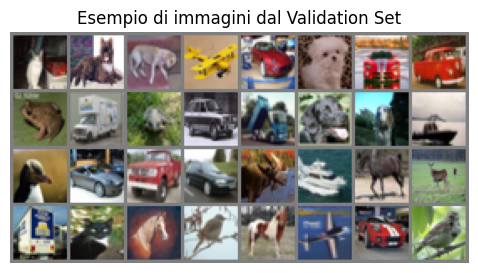

In [9]:
# Dimension original test set 
test_size = len(testset_norm)
val_size = test_size // 2           # half for validation
final_test_size = test_size - val_size

# Random splitting of test set 
valset, testset_final = torch.utils.data.random_split(testset_norm, [val_size, final_test_size])

#Dataloader creation's for validation and final test
val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
test_loader_final = torch.utils.data.DataLoader(testset_final, batch_size=batch_size,
                                                shuffle=False, num_workers=2)

print(f"Totale immagini nel test set originale: {test_size}")
print(f"Immagini nel validation set: {len(valset)}")
print(f"Immagini nel test set finale: {len(testset_final)}")

# Visualization of some images from the validation set
dataiter = iter(val_loader)
images, labels = next(dataiter)

fig, ax = plt.subplots(figsize=(10, 3))
imshow_noshow(torchvision.utils.make_grid(images), ax)
ax.set_title("Esempio di immagini dal Validation Set")
plt.show()

### Task 5 
Starting from the code provided during Lecture 6, define a ConvNet. You can **only** use:

- Convolutional layers  
- Max/Avg Pooling layers  
- Activation Functions  
- Fully connected layers  

Note that the choice `Conv - Pool - Conv` is not mandatory. Have you tried `Conv - Conv - Activ - Pool - Conv - Conv - Activ - Pool - FC`?  
For each convolutional layer you can choose padding and stride. Be prepared on comment on the choices of the dimensions of the layers.

In [10]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        # Convolutional blocks 
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Fully-connected Blocks 
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Model Initialization 
net = ConvNet()
print(net)

# Verification of the forward pass on a sample batch
dataiter = iter(trainloader)
images, labels = next(dataiter)
outputs = net(images)
print(f"Input shape:  {images.shape}")
print(f"Output shape: {outputs.shape}")

ConvNet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)
Input shape:  torch.Size([32,

### Task 6 
Implement the training pipeline. Make sure to code the following:

- Print and record the current training loss and accuracy every *n* steps (choose *n*)  
- Print and record the current validation loss and accuracy every *n* steps (choose *n*)  

The validation loss will help you in hyperparameter tuning. Train your model.  
With my choice of hyperparameters, the best test accuracy is above **65%**, hence, a necessary condition to get full marks is to achieve an accuracy on the test set greater or equal to **65%**.

You may want to follow some of these hints (**They are, of course, dependent on the architecture, optimizer, ...**):

- 5 epochs should be enough  
- Batch size = 32 could be a good starting point  
- A learning rate around 0.03 should be a good tradeoff between speed and stability  
- SGD should be a good optimizer  


In [11]:
#Initialisation
new_batch_size = 32     #set the batch size as given 

# Re-create DataLoaders (using the datasets already loaded and split in the previous tasks)
trainloader = torch.utils.data.DataLoader(trainset_norm, batch_size=new_batch_size,
                                          shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(valset, batch_size=new_batch_size,
                                         shuffle=False, num_workers=2)
test_loader_final = torch.utils.data.DataLoader(testset_final, batch_size=new_batch_size,
                                                shuffle=False, num_workers=2)

print(f"Data loader recreated with batch size = {new_batch_size}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}")

# Rate (defined in task 5) and Loss
net = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.03, momentum=0.9) #using hyperparameter as given

# Training Pipeline 

# Parameters:
epochs = 5       #as given 
n_print = 200    #Print every 200 batch
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    net.train()
    running_loss, correct, total = 0.0, 0, 0

    # (50000 image / 32 batch_size) = 1563 step for each epoc 
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Statistics 
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if (i + 1) % n_print == 0:
            # Compute the average over n_print batches
            train_loss = running_loss / n_print
            train_acc = 100 * correct / total
            print(f"[Epoch {epoch+1}, Step {i+1}] Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}%")
            
            # Save statistics
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            
            # Reset Counters 
            running_loss, correct, total = 0.0, 0, 0

    # Validation: at the end of each epoch
    net.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accs.append(val_accuracy)
    print(f"--- Epoch [{epoch+1}/{epochs}] - Validation Loss: {avg_val_loss:.3f} | Validation Acc: {val_accuracy:.2f}% ---")

print("\nTraining completed!")

# Ealuation on the final test set 
net.eval()
test_loss, test_correct, test_total = 0.0, 0, 0
with torch.no_grad():
    for images, labels in test_loader_final:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

final_test_acc = 100 * test_correct / test_total
avg_test_loss = test_loss / len(test_loader_final)

print(f"\nTest Loss: {avg_test_loss:.3f} | Test Accuracy: {final_test_acc:.2f}%")

if final_test_acc >= 65:
    print("Condition satisfied: Test accuracy ≥ 65%!")
else:
    print("Accuracy below the required threshold (65%).")

Data loader recreated with batch size = 32
Training on device: cuda
[Epoch 1, Step 200] Train Loss: 2.203 | Train Acc: 17.06%
[Epoch 1, Step 400] Train Loss: 1.889 | Train Acc: 28.80%
[Epoch 1, Step 600] Train Loss: 1.692 | Train Acc: 37.95%
[Epoch 1, Step 800] Train Loss: 1.555 | Train Acc: 42.28%
[Epoch 1, Step 1000] Train Loss: 1.437 | Train Acc: 47.47%
[Epoch 1, Step 1200] Train Loss: 1.355 | Train Acc: 50.69%
[Epoch 1, Step 1400] Train Loss: 1.291 | Train Acc: 52.94%
--- Epoch [1/5] - Validation Loss: 1.219 | Validation Acc: 55.58% ---
[Epoch 2, Step 200] Train Loss: 1.127 | Train Acc: 59.95%
[Epoch 2, Step 400] Train Loss: 1.127 | Train Acc: 61.09%
[Epoch 2, Step 600] Train Loss: 1.081 | Train Acc: 62.27%
[Epoch 2, Step 800] Train Loss: 1.028 | Train Acc: 63.83%
[Epoch 2, Step 1000] Train Loss: 1.060 | Train Acc: 62.72%
[Epoch 2, Step 1200] Train Loss: 1.018 | Train Acc: 64.72%
[Epoch 2, Step 1400] Train Loss: 1.017 | Train Acc: 64.58%
--- Epoch [2/5] - Validation Loss: 0.970 | V

### Task 7 (4 pts)
Plot the evolution of the training and validation losses on the same graph. On the x-axis, you should preferably use the number of steps. Do you observe signs of overfitting or underfitting? Note that an improperly trained model will also result in a point deduction for the previous exercise.

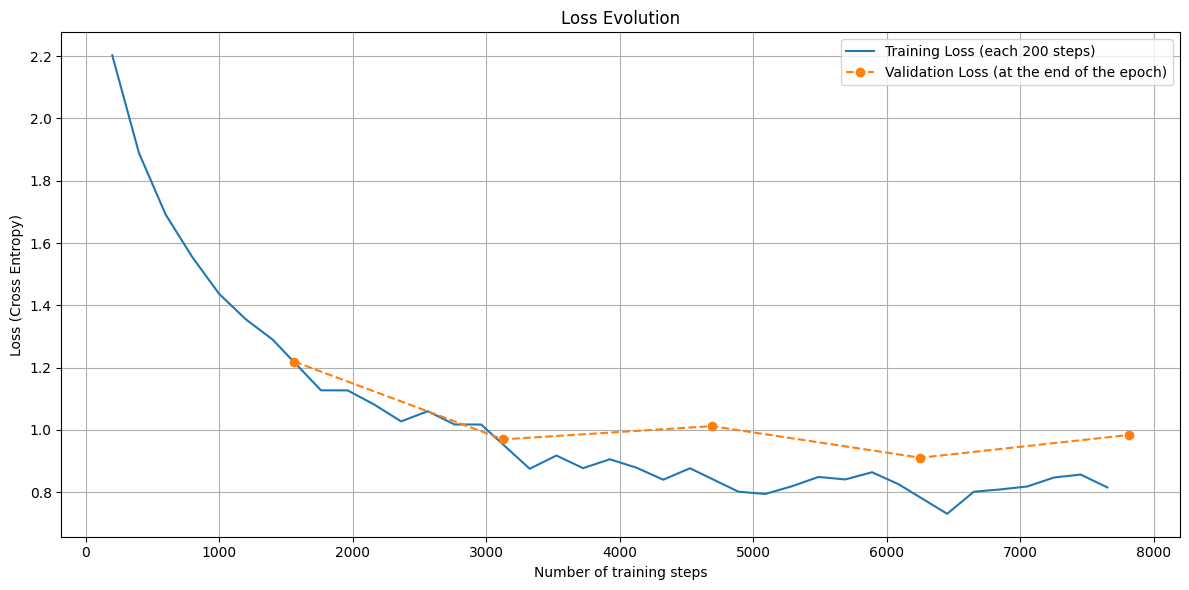

In [12]:

# Preparation of the data for plotting 
# Training data (example 35 points, 7 per epoch * 5 epochs)
train_losses_data = train_losses 

# Validation data (ex. 5 points, 1 per epoch)
val_losses_data = val_losses

# Compute the totoal steps for each epoch (es. 50000 / 32 = 1563)
steps_per_epoch = len(trainloader) 

# Number of training outputs per epoch
n_prints_per_epoch = steps_per_epoch // n_print

# Creation X axis that represent the Number of steps 
# X axis per points of Training Loss
train_x_steps = []      
for epoch in range(epochs):
    for i in range(n_prints_per_epoch):
        step = (epoch * steps_per_epoch) + ((i + 1) * n_print)
        train_x_steps.append(step)

# X-axis for Validation Loss points (computed at the end of the epoch)
val_x_steps = [ (e + 1) * steps_per_epoch for e in range(epochs) ]

# Plotting
plt.figure(figsize=(12, 6))
# Plot  training loss
plt.plot(train_x_steps, train_losses_data, label='Training Loss (each 200 steps)')

# Plot validation loss 
plt.plot(val_x_steps, val_losses_data, label='Validation Loss (at the end of the epoch)', 
         linestyle='--', marker='o')

plt.title(f"Loss Evolution")
plt.xlabel("Number of training steps")
plt.ylabel("Loss (Cross Entropy)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Task 8 (20 pts)
You may have noticed that it is quite likely to get overfitting in many cases, preventing it from going beyond 65% accuracy.  

Change the architecture as you like and try to increase the accuracy as much as possible. The base architecture must remain a ConvNet.  
Try any idea that comes to your mind but **justify it**.

Some hints:

- Add Dropout (Any other hyperparameter to tune?)  
- Change activation functions ([GeLU](https://arxiv.org/pdf/1606.08415v3.pdf) is known to work well with images)  
- Make your CNN deeper  
- Add some regularization techniques  
- Change the optimizer  
- Data augmentation  
- Batch normalization  
- …  

#### Points distribution:
- Accuracy on test set ≥ 78% should be very good.  

To get the remaining 5 points you should be able also justify your choices (e.g., “I used Dropout because … and hence I have increased epochs as I noted …”).  

**Note:** Transfer learning is **not allowed** — otherwise you can complete this exercise easily, and it is not useful for educational purposes.

Dataloader aggiornati con Augmentation (Train) e Batch Size 32
Training on device: cuda
--- Starting training model v2 (con BN, Dropout, Augmentation) ---
[Epoch 1, Step 500] Train Loss: 1.961 | Train Acc: 26.18%
[Epoch 1, Step 1000] Train Loss: 1.710 | Train Acc: 34.01%
[Epoch 1, Step 1500] Train Loss: 1.586 | Train Acc: 39.91%
--- Epoch [1/20] - Validation Loss: 1.284 | Validation Acc: 51.82% ---
[Epoch 2, Step 500] Train Loss: 1.500 | Train Acc: 43.60%
[Epoch 2, Step 1000] Train Loss: 1.439 | Train Acc: 46.58%
[Epoch 2, Step 1500] Train Loss: 1.383 | Train Acc: 49.15%
--- Epoch [2/20] - Validation Loss: 1.070 | Validation Acc: 60.66% ---
[Epoch 3, Step 500] Train Loss: 1.306 | Train Acc: 51.73%
[Epoch 3, Step 1000] Train Loss: 1.263 | Train Acc: 54.58%
[Epoch 3, Step 1500] Train Loss: 1.218 | Train Acc: 55.83%
--- Epoch [3/20] - Validation Loss: 0.923 | Validation Acc: 66.64% ---
[Epoch 4, Step 500] Train Loss: 1.169 | Train Acc: 57.66%
[Epoch 4, Step 1000] Train Loss: 1.155 | Train

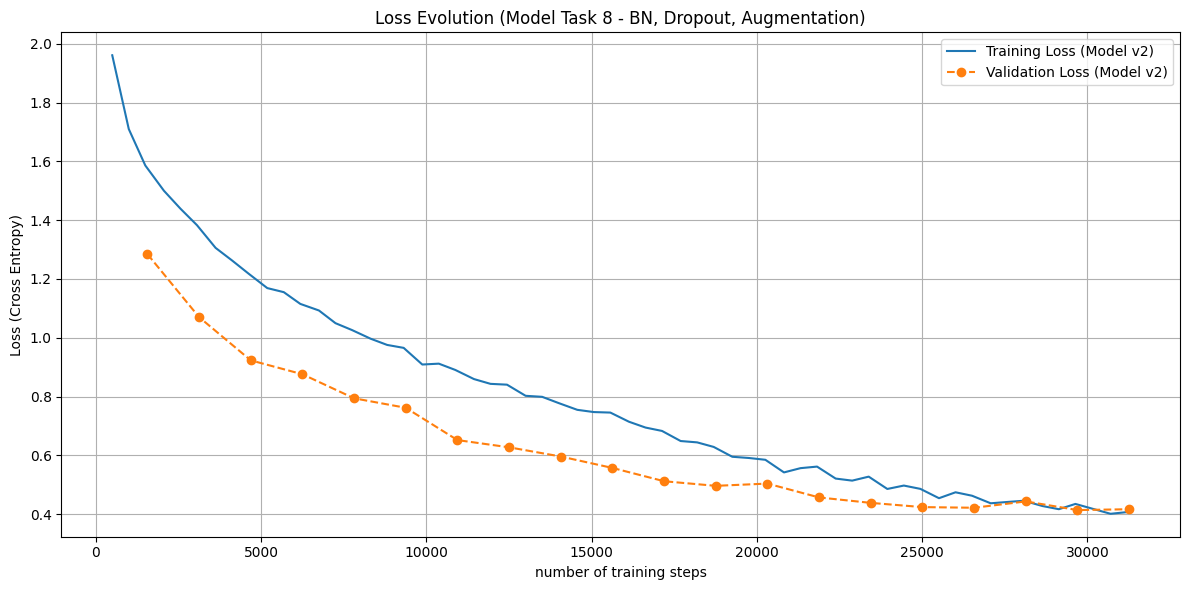

In [13]:
# Data Augmentation 
# Trasfomation for Training Set (with augmentation)
transform_train_aug = transforms.Compose([
    transforms.RandomCrop(32, padding=4),      # Random crop with padding
    transforms.RandomHorizontalFlip(),       # Random horizontal flip
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Traformation for Validation and Test Set (without augmentation )
transform_val_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

#Reload dataset with augmenation 

new_batch_size = 32     #set batch size 

# Reload dataset with new trasformations 
trainset_aug = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=False, transform=transform_train_aug)

# Reload the validation and test sets
testset_orig = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=False, transform=transform_val_test)
val_size = len(testset_orig) // 2
test_size = len(testset_orig) - val_size
valset_aug, testset_final_aug = torch.utils.data.random_split(testset_orig, [val_size, test_size])


# DataLoader Creation 
trainloader = torch.utils.data.DataLoader(trainset_aug, batch_size=new_batch_size,
                                          shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(valset_aug, batch_size=new_batch_size,
                                         shuffle=False, num_workers=2)
test_loader_final = torch.utils.data.DataLoader(testset_final_aug, batch_size=new_batch_size,
                                                shuffle=False, num_workers=2)

print(f"Dataloader aggiornati con Augmentation (Train) e Batch Size {new_batch_size}")


# V2 Architecture (with batch norm and dropout)

class ConvNet_v2(nn.Module):
    def __init__(self):
        super(ConvNet_v2, self).__init__()

        # Structure: Conv -> BatchNorm -> ReLU -> Pool
        self.conv_layers = nn.Sequential(
            # Block 1 
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # Dim: 16x16

            # Block 2
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # Dim: 8x8

            # Block 3
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # Dim: 4x4
        )

        # Fully-connected blocks (with dropout)
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 256), # 4096 -> 256
            nn.ReLU(),
            nn.Dropout(0.5), # Add Dropout (50%)
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


# Training Pipeline 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}")

net = ConvNet_v2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001) # optimizer: Adam (usally faster then SGD)

epochs = 20     # Epochs: 20 (needed more epochs for regularization)
n_print = 500  

# List of plots
task8_train_losses, task8_val_losses = [], []
task8_train_accs, task8_val_accs = [], []

print("--- Starting training model v2 (con BN, Dropout, Augmentation) ---")

for epoch in range(epochs):
    net.train()
    running_loss, correct, total = 0.0, 0, 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if (i + 1) % n_print == 0:
            train_loss = running_loss / n_print
            train_acc = 100 * correct / total
            print(f"[Epoch {epoch+1}, Step {i+1}] Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}%")
            task8_train_losses.append(train_loss)
            task8_train_accs.append(train_acc)
            running_loss, correct, total = 0.0, 0, 0

    # VALIDAZIONE
    net.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    task8_val_losses.append(avg_val_loss)
    task8_val_accs.append(val_accuracy)
    print(f"--- Epoch [{epoch+1}/{epochs}] - Validation Loss: {avg_val_loss:.3f} | Validation Acc: {val_accuracy:.2f}% ---")

print("\nTraining v2 completato!")

# Final evaluation
net.eval()
test_loss, test_correct, test_total = 0.0, 0, 0
with torch.no_grad():
    for images, labels in test_loader_final:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

final_test_acc = 100 * test_correct / test_total
avg_test_loss = test_loss / len(test_loader_final)

print(f"\n Task 8 result- Test Loss: {avg_test_loss:.3f} | Test Accuracy: {final_test_acc:.2f}%")

if final_test_acc >= 78:
    print("Eccellente result: Test accuracy ≥ 78%!")
elif final_test_acc >= 70:
    print("Good result: Test accuracy ≥ 70%!")
else:
    print("Accuracy under the request standars (70%). Need to change hyperparameters")

# Plotting new data

# Let’s calculate the total steps per epoch
steps_per_epoch = len(trainloader) 
# Number of training prints per epoch
n_prints_per_epoch = steps_per_epoch // n_print

# X-axis for Training Loss points
train_x_steps = []
for epoch in range(epochs):
    for i in range(n_prints_per_epoch):
        step = (epoch * steps_per_epoch) + ((i + 1) * n_print)
        train_x_steps.append(step)

# X-axis for validation loss points 
val_x_steps = [ (e + 1) * steps_per_epoch for e in range(epochs) ]

plt.figure(figsize=(12, 6))
plt.plot(train_x_steps, task8_train_losses, label='Training Loss (Model v2)')
plt.plot(val_x_steps, task8_val_losses, label='Validation Loss (Model v2)', 
         linestyle='--', marker='o')
plt.title("Loss Evolution (Model Task 8 - BN, Dropout, Augmentation)")
plt.xlabel("number of training steps")
plt.ylabel("Loss (Cross Entropy)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Task 9 (10 pts)

Until now, we asked you to keep the seed fixed.  
Train **the model you defined at Task 5** five times with 5 different seeds (already specified below, **don't change them**), each for the same number of epochs epochs.  
Don't change other hyperparameters. Observe the accuracy of the test set in each case. What can you say?  

In [14]:
# Define class of the model (task 5)
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # Convoltional block
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        # Fully-connected block
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


new_batch_size = 32
lr = 0.03
momentum = 0.9
epochs = 5 # Same epochs task 6

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using of device: {device}")

# DataLoaders (re-defined for the training loop)
trainloader = torch.utils.data.DataLoader(trainset_norm, batch_size=new_batch_size,
                                          shuffle=True, num_workers=2)
test_loader_final = torch.utils.data.DataLoader(testset_final, batch_size=new_batch_size,
                                                shuffle=False, num_workers=2)

# Seed list to test 
seeds = [0, 1, 2, 3, 4]
test_accuracies = []

# Training loop
for seed in seeds:
    print(f"\n--- Training with seed: {seed} ---")
    
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    #  Re-initialize the model
    net = ConvNet().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)

    # Training (5 epochs)
    for epoch in range(epochs):
        net.train()
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        print(f"Seed {seed}, Epoch {epoch+1}/{epochs} completed.")

    # Evaluation test set (after 5 epochs)
    net.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader_final:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    final_test_acc = 100 * test_correct / test_total
    test_accuracies.append(final_test_acc)
    print(f" Seed {seed} - Final Test Accuracy: {final_test_acc:.2f}%")

# Summary results 
print("\n--- Summary Task 9 ---")
print(f"Accuracy obtained for the 5 seeds: {test_accuracies}")
print(f"Average Accuracy: {np.mean(test_accuracies):.2f}%")
print(f"Standard deviation: {np.std(test_accuracies):.2f}")
print(f"Max Accuracy: {np.max(test_accuracies):.2f}%")
print(f"Min Accuracy: {np.min(test_accuracies):.2f}%")


Using of device: cuda

--- Training with seed: 0 ---
Seed 0, Epoch 1/5 completed.
Seed 0, Epoch 2/5 completed.
Seed 0, Epoch 3/5 completed.
Seed 0, Epoch 4/5 completed.
Seed 0, Epoch 5/5 completed.
 Seed 0 - Final Test Accuracy: 65.60%

--- Training with seed: 1 ---
Seed 1, Epoch 1/5 completed.
Seed 1, Epoch 2/5 completed.
Seed 1, Epoch 3/5 completed.
Seed 1, Epoch 4/5 completed.
Seed 1, Epoch 5/5 completed.
 Seed 1 - Final Test Accuracy: 64.14%

--- Training with seed: 2 ---
Seed 2, Epoch 1/5 completed.
Seed 2, Epoch 2/5 completed.
Seed 2, Epoch 3/5 completed.
Seed 2, Epoch 4/5 completed.
Seed 2, Epoch 5/5 completed.
 Seed 2 - Final Test Accuracy: 65.32%

--- Training with seed: 3 ---
Seed 3, Epoch 1/5 completed.
Seed 3, Epoch 2/5 completed.
Seed 3, Epoch 3/5 completed.
Seed 3, Epoch 4/5 completed.
Seed 3, Epoch 5/5 completed.
 Seed 3 - Final Test Accuracy: 68.92%

--- Training with seed: 4 ---
Seed 4, Epoch 1/5 completed.
Seed 4, Epoch 2/5 completed.
Seed 4, Epoch 3/5 completed.
Seed